生存率、疾病进展和治疗反应

描述： 由结肠癌患者样本的临床和分子信息组成的元数据： 由结肠癌患者样本的临床和分子信息组成的元数据。该数据已从源数据中过滤，只保留 II/III 期结肠癌样本。

需要注意的关键信息：红色突出显示的列是您的癌症复发或生存结果。
- rfs_event 表示无复发生存事件；0 表示事件（复发）未发生，1 表示事件（复发）已发生。
- rfs_months 表示事件（复发）发生前的持续时间，以月为单位。
- os_event，与 rfs 类似，但这是总生存期，表示患者是死亡 1，还是仍然存活 0。
- s_months，事件（死亡）发生前的月份。

您可能感兴趣的其他分子和病理信息用绿色标出（但不是必须的）：
- age_at_diagnosis（诊断时年龄）：患者首次被诊断为结肠癌时的年龄。
- sex：患者的性别
- tnm_stage：患者的癌症分期。
- chemotherapy_adjuvant（辅助化疗）：患者手术后是否接受了化疗？ 是或否
- chemotherapy_adjuvant_type（辅助化疗类型）： 患者接受了哪种化疗？

突出显示为黄色（我们小组感兴趣的一些分子亚型，也许对您的项目并不重要）：
- CMS： 共识分子亚型
- PDS：途径衍生亚型

#### 加载必要的库

In [26]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

### 加载数据

In [27]:
# 加载数据集
data_path = 'gse39582_n469_clinical_data.xlsx'
model_path = 'model.pkl'

data_raw = pd.read_excel(data_path)

In [4]:
data_raw.head()

,Sample_ID,title,status,submission_date,last_update_date,organism,dataset,sex,age_at_diagnosis_in_years,tnm_stage,...,kras_mutation_exon_number,kras_mutation_protein,braf_mutation,braf_mutation_dna,braf_mutation_exon_number,braf_mutation_protein,cit_molecular_subtype,CMS,PDS_call,name
0,GSM971959,CIT003,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,36.9,2,...,NaN,NaN,WT,NaN,NaN,NaN,C3,CMS3,PDS1,NaN
1,GSM971962,CIT006,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,60.9,3,...,NaN,NaN,WT,NaN,NaN,NaN,C4,CMS4,PDS2,NaN
2,GSM971963,CIT007,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Male,78.2,2,...,NaN,NaN,WT,NaN,NaN,NaN,C2,CMS1,PDS2,NaN
3,GSM971964,CIT008,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Female,35.4,3,...,NaN,NaN,WT,NaN,NaN,NaN,C1,CMS2,PDS1,NaN
4,GSM971965,CIT009,Public on May 22 2013,Jul 23 2012,Jun 18 2021,Homo sapiens,discovery,Female,37.5,2,...,c.35G>A,p.G12D,WT,NaN,NaN,NaN,C1,UNK,PDS3,NaN


In [ ]:
data_raw.info()

In [28]:
data = data_raw[['sex', 
                 'age_at_diagnosis_in_years', 
                 'tnm_stage', 
                 'chemotherapy_adjuvant', 
                 'chemotherapy_adjuvant_type',
                 'rfs_event',
                 'rfs_months',
                 'os_event',
                 'os_months',
                 'CMS',
                 'PDS_call']]


In [ ]:
# 设置图的大小
plt.figure(figsize=(10, 5))

# 绘制countplot
sns.countplot(x='os_event', data=data)

In [29]:
# 查看哪些字段有空
data.isnull().sum()

sex                             0
age_at_diagnosis_in_years       0
tnm_stage                       0
chemotherapy_adjuvant           2
chemotherapy_adjuvant_type    325
rfs_event                       8
rfs_months                      5
os_event                        6
os_months                       3
CMS                             0
PDS_call                        0
dtype: int64

In [ ]:
# 对源数据集进行描述
data.describe(include='all')

In [30]:
# 对数据集进行清理
data.dropna(subset=['chemotherapy_adjuvant', 'rfs_event', 'rfs_months', 'os_event', 'os_months'], inplace=True)

/var/folders/1_/vzcn0wp93dv8qshp0tmkb16c0000gn/T/ipykernel_86926/1727950543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset=['chemotherapy_adjuvant', 'rfs_event', 'rfs_months', 'os_event', 'os_months'], inplace=True)


In [31]:
# 查看哪些字段有空
data.isnull().sum()

sex                             0
age_at_diagnosis_in_years       0
tnm_stage                       0
chemotherapy_adjuvant           0
chemotherapy_adjuvant_type    317
rfs_event                       0
rfs_months                      0
os_event                        0
os_months                       0
CMS                             0
PDS_call                        0
dtype: int64

In [32]:
data['sex_numeric'] = data['sex'].map({'Male': 0, 'Female': 1})

# 将chemotherapy_adjuvant中的'N'变成0，'Y'变成1
data['chemotherapy_adjuvant_numeric'] = data['chemotherapy_adjuvant'].map({'N': 0, 'Y': 1})

# 为chemotherapy_adjuvant_type定义新的label
# 假设有6种类型，这里需要根据实际情况来定义映射，下面的映射只是一个示例
chemo_type_mapping = {'N/A': 0, '5FU': 1, 'FOLFIRI': 2, 'FOLFOX': 3, 'FUFOL': 4, 'other': 5}
data['chemotherapy_adjuvant_type_numeric'] = data['chemotherapy_adjuvant_type'].map(chemo_type_mapping)
# 填充NaN值为0，假设NaN代表没有接受化疗
data['chemotherapy_adjuvant_type_numeric'] = data['chemotherapy_adjuvant_type_numeric'].fillna(0)

# 为CMS定义标签
cms_mapping = {'CMS1': 1, 'CMS2': 2, 'CMS3': 3, 'CMS4': 4, 'UNK': 0}  # 假设UNK代表未知，赋值为0
data['CMS_numeric'] = data['CMS'].map(cms_mapping)

# 为PDS_call定义标签
pds_call_mapping = {'PDS1': 1, 'PDS2': 2, 'PDS3': 3, 'Mixed': 4}
data['PDS_call_numeric'] = data['PDS_call'].map(pds_call_mapping)

# 删除原来的列
data.drop(['sex', 'chemotherapy_adjuvant', 'chemotherapy_adjuvant_type', 'CMS', 'PDS_call'], axis=1, inplace=True)

# 查看处理后的前几行数据以确保一切按预期进行
print(data.head())


   age_at_diagnosis_in_years  tnm_stage  rfs_event  rfs_months  os_event  \
0                       36.9          2        1.0         4.0       0.0   
1                       60.9          3        0.0        73.0       0.0   
2                       78.2          2        1.0        17.0       1.0   
3                       35.4          3        0.0        35.0       0.0   
4                       37.5          2        0.0        33.0       0.0   

   os_months  sex_numeric  chemotherapy_adjuvant_numeric  \
0       52.0            0                              0   
1       73.0            0                              1   
2       20.0            0                              1   
3       35.0            1                              0   
4       33.0            1                              0   

   chemotherapy_adjuvant_type_numeric  CMS_numeric  PDS_call_numeric  
0                                 0.0            3                 1  
1                                 0.0   

/var/folders/1_/vzcn0wp93dv8qshp0tmkb16c0000gn/T/ipykernel_86926/1975089487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sex_numeric'] = data['sex'].map({'Male': 0, 'Female': 1})
/var/folders/1_/vzcn0wp93dv8qshp0tmkb16c0000gn/T/ipykernel_86926/1975089487.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['chemotherapy_adjuvant_numeric'] = data['chemotherapy_adjuvant'].map({'N': 0, 'Y': 1})
/var/folders/1_/vzcn0wp93dv8qshp0tmkb16c0000gn/T/ipykernel_86926/1975089487.py:9: SettingWithCopyWar

In [ ]:
data['chemotherapy_adjuvant_type_numeric'].value_counts()

In [ ]:
data['sex_numeric'].value_counts()

In [ ]:
data['chemotherapy_adjuvant_numeric'].value_counts()

In [ ]:
data['CMS_numeric'].value_counts()

In [ ]:
data['PDS_call_numeric'].value_counts()

In [ ]:
data.isnull().sum()

### 构建特征

#### 1. 生存率 Survival Rate

In [34]:
Target_survival = ['os_event']

In [38]:
data_columns_survival = ['rfs_event', 'rfs_months', 'os_months']

In [39]:
columns_survival = Target_survival + data_columns_survival

In [40]:
X_train_1, X_test_1, y_train_1, y_test_1 = model_selection.train_test_split(data[data_columns_survival], 
                                                                    data[Target_survival], 
                                                                    random_state=0)

In [ ]:
X_train_1.shape

In [ ]:
y_train_1.shape

In [ ]:
X_test_1.shape

In [ ]:
y_test_1.shape

#### 2. 疾病发展 Disease Progression

In [41]:
Target_progression = ['os_event']

In [42]:
data_columns_progression = ['tnm_stage', 
                            'chemotherapy_adjuvant_numeric', 
                            'chemotherapy_adjuvant_type_numeric', 
                            'CMS_numeric',
                            'PDS_call_numeric']

In [43]:
columns_progression = Target_progression + data_columns_progression

In [44]:
X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(data[columns_progression], 
                                                                    data[Target_progression], 
                                                                    random_state=0)

In [ ]:
X_train_2.shape

In [ ]:
y_train_2.shape

In [ ]:
X_test_2.shape

In [ ]:
y_test_2.shape

#### 3. 治疗反应 Treatment Response

In [45]:
Target_response = ['os_event']

In [46]:
data_columns_response = ['age_at_diagnosis_in_years', 
                         'sex_numeric', 
                         'tnm_stage', 
                         'chemotherapy_adjuvant_numeric', 
                         'chemotherapy_adjuvant_type_numeric', 
                         'CMS_numeric', 
                         'PDS_call_numeric']

In [47]:
columns_response = Target_response + data_columns_response

In [48]:
X_train_3, X_test_3, y_train_3, y_test_3 = model_selection.train_test_split(data[columns_response], 
                                                                    data[Target_response], 
                                                                    random_state=0)

In [ ]:
X_train_3.shape

In [ ]:
y_train_3.shape

In [ ]:
X_test_3.shape

In [ ]:
y_test_3.shape

### 随机森林算法 Random Forest

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf = RandomForestClassifier(random_state=1,
                            n_jobs=-1)

In [51]:
param_gird = {
    'criterion':['gini', 'entropy'],
    'min_samples_leaf':[1, 5, 10],
    'min_samples_split':[2, 4, 10, 12, 16],
    'n_estimators': [50, 100, 400, 700, 1000]
}

In [52]:
gs = GridSearchCV(estimator=rf,
                  param_grid=param_gird,
                  scoring='accuracy',
                  cv=3,
                  n_jobs=-1)

#### 1. 生存率 Survival Rate

In [53]:
gs_1 = gs.fit(X_train_1, y_train_1)

0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
338.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.20s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
338.27s - pydevd: Sending message re

In [54]:
print(gs_1.best_score_)

0.8057971014492754


In [55]:
print(gs_1.best_params_)

{'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 400}


In [56]:
# 创建一个对象
rf_1 = RandomForestClassifier(criterion='gini',
                            min_samples_leaf=5,
                            min_samples_split=16,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

In [57]:
rf_1.fit(X_train_1, y_train_1)

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_leaf=5, min_samples_split=16,
                       n_estimators=50, n_jobs=-1, random_state=1)

In [58]:
# 预测
# 根据特征的重要性排序
pd.concat((pd.DataFrame(X_train_1.iloc[:, 1:].columns, columns=['Variable']),
           pd.DataFrame(rf_1.feature_importances_, columns=['importance'])),
           axis=1).sort_values(by='importance', ascending=False)

,Variable,importance
1,os_months,0.407116
2,NaN,0.326180
0,rfs_months,0.266703


 #### 在test上进行预测

In [59]:
pred_1 = rf_1.predict(X_test_1)

In [60]:
pred_df_1 = pd.DataFrame(pred_1, columns=['os_event'])

In [61]:
pred_df_1.head()

,os_event
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


Accuracy: 0.82
ROC AUC: 0.72


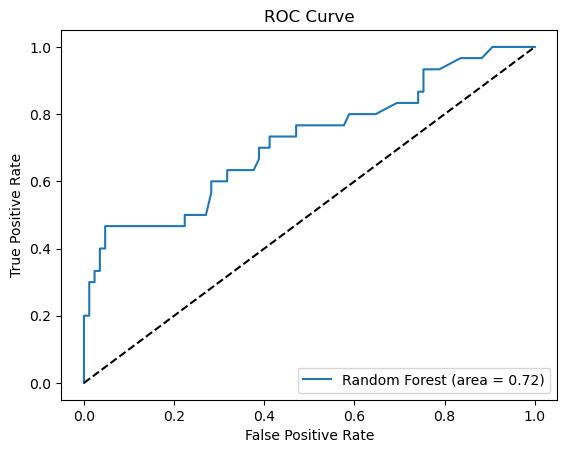

In [62]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 假设rf2是已经训练好的模型，X_test是测试特征，y_test是测试标签

# 使用模型预测测试集的概率
y_pred_proba_1 = rf_1.predict_proba(X_test_1)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test_1, rf_1.predict(X_test_1))
print(f'Accuracy: {accuracy:.2f}')

# 计算AUC值
roc_auc = roc_auc_score(y_test_1, y_pred_proba_1)
print(f'ROC AUC: {roc_auc:.2f}')

# 生成ROC曲线的值：fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_proba_1)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角虚线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


#### 2. 疾病发展 Disease Progression

In [63]:
gs_2 = gs.fit(X_train_2, y_train_2)

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [64]:
print(gs_2.best_score_)

1.0


In [65]:
print(gs_2.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# 创建一个对象
rf_2 = RandomForestClassifier(criterion='gini',
                            min_samples_leaf=1,
                            min_samples_split=2,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

In [ ]:
rf_2.fit(X_train_2, y_train_2)

In [ ]:
pred_2 = rf_2.predict(X_test_2)

In [ ]:
pred_df_2 = pd.DataFrame(pred_2, columns=['os_event'])

In [ ]:
# 使用模型预测测试集的概率
y_pred_proba_2 = rf_2.predict_proba(X_test_2)[:, 1]

# 计算准确率
accuracy = accuracy_score(y_test_2, rf_2.predict(X_test_2))
print(f'Accuracy: {accuracy:.2f}')

# 计算AUC值
roc_auc = roc_auc_score(y_test_2, y_pred_proba_2)
print(f'ROC AUC: {roc_auc:.2f}')

# 生成ROC曲线的值：fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_proba_2)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角虚线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### 3. 治疗反应 Treatment Response

In [66]:
gs_3 = gs.fit(X_train_3, y_train_3)

/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/nancyxie/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. P

In [67]:
print(gs_3.best_score_)

1.0


In [68]:
print(gs_3.best_params_)

{'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# 创建一个对象
rf_3 = RandomForestClassifier(criterion='gini',
                            min_samples_leaf=5,
                            min_samples_split=16,
                            n_estimators=50,
                            n_jobs=-1,
                            random_state=1)

### 保存模型

In [194]:
# 保存模型
joblib.dump(rf_1, model_path)

['model.pkl']

-----